# Bayesian Modeling with MCMC

In the previous section we explored a Bayesian solution to a straight line fit.
The result made use of the evaluation of a posterior across a grid of parameters: a strategy that *will not* scale to higher-dimensional models.

## The Curse of Dimensionality

The reason it will not scale is one of the effects of the ubiquitous "Curse of Dimensionality". To understand this, consider how many evaluations we need for an $N$-dimensional grid with 100 samples per dimension

In one dimension, we have $100$ points.

In two dimensions we have $100^2 = 10,000$ evaluations.

In three dimensions, we have $100^3 = 1,000,000$ evaluations.

In $N$ dimensions, we have $100^N$ evaluations, and as $N$ grows this quickly becomes untenable! For example, if we have only six model parameters, this "dense grid" approach will require evaluating the posterior at one trillion grid points, the results of which would require several terabytes of memory just to store!

Evidently the dense grid strategy will not work for any but the simplest Bayesian models.

## Circumventing the Curse with Sampling

An idea that revolutionized Bayesian modeling (and made possible the wide variety of Bayesian approaches used in practice today) is *Markov Chain Monte Carlo* (MCMC), an approach that allows one to efficiently draw (pseudo)random samples from a posterior distribution even in relatively high dimensions.

### The Metropolis-Hastings Sampler

Perhaps the simplest of MCMC samplers is the *Metropolis-Hastings Sampler*.
This provides a procedure which, given a pseudo-random number generator, selects a chain of points which (in the long-term limit) will be a representative sample from the posterior. The procedure is surprisingly simple:

1. Define a posterior $p(\theta~|~D, I)$
2. Define a *proposal density* $p(\theta_{i + 1}~|~\theta_i)$, which must be a symmetric function, but otherwise is unconstrained (a Gaussian is the usual choice).
3. Choose a starting point $\theta_0$
4. Repeat the following:

   1. Given $\theta_i$, draw a new $\theta_{i + 1}$
   
   2. Compute the *acceptance ratio*
      $$
      a = \frac{p(\theta_{i + 1}~|~D,I)}{p(\theta_i~|~D,I)}
      $$
   
   3. If $a \ge 1$, the proposal is more likely: accept the draw and add $\theta_{i + 1}$ to the chain.
   
   4. If $a < 1$, then accept the point with probability $a$: this can be done by drawing a uniform random number $r$ and checking if $a < r$. If the point is accepted, add $\theta_{i + 1}$ to the chain. If not, then add $\theta_i$ to the chain *again*.

There are a few caveats to be aware of when using MCMC

#### 1. The procedure is provably correct... but only in the long-term limit!

Sometimes the long-term limit is **very** long. What we're looking for is "stabilization" of the MCMC chain, meaning that it has reached a statistical equilibrium. There is a vast literature on how to measure stabilization of an MCMC chain. Here we'll use the sloppy but intuitive LAI approach (i.e. Look At It).

#### 2. The size of the proposal distribution is *very* important

- If your proposal distribution is too small, it will take too long for your chain to move, and you have the danger of getting stuck in a local maximum for a long (but not infinite) time.

- If your proposal distribution is too large, you will not be able to efficiently explore the space around a particular peak

In general, choosing an appropriate scale for the proposal distribution is one of the most difficult parts of using the MCMC procedure above.
More sophisticated methods (such as what we will use below) have built-in ways to estimate this along the way, but it's still something to be aware of!

#### 3. Fast Stabilization can be helped by good initialization

In practice, assuring that MCMC will stabilize quickly has a lot to do with choosing a suitable initialization. For this purpose, it can be useful to find the maximum a posteriori (MAP) value, and initialize the chain with this.

A bit later in the session, we will spend some time actually coding a simple Metropolis-Hastings sampler which uses the above procedure.
But first let's take a look at MCMC in action.

## Sampling with ``emcee``

There are several good Python approaches to Bayesian computation with MCMC. You can read about some of them in this blog post: [How to Be a Bayesian in Python](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/).

Here we'll focus on [``emcee``](http://dan.iel.fm/emcee/), a lightweight Python package developed by Dan Foreman-Mackey and collaborators.
One benefit of ``emcee`` is that it uses an *ensemble sampler* which automatically tunes the shape and size of the proposal distribution (you can read more details in the ``emcee`` documentation).

### Creating some Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn; seaborn.set() # for plot formatting

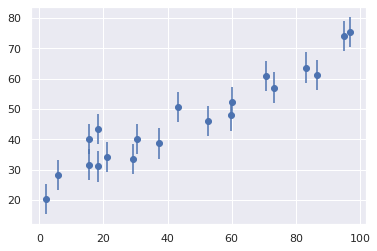

In [2]:
def make_data(intercept, slope, N=20, dy=5, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(N)
    y = intercept + slope * x
    y += dy * rand.randn(N)
    return x, y, dy * np.ones_like(x)

theta_true = (25, 0.5)
x, y, dy = make_data(*theta_true)

plt.errorbar(x, y, dy, fmt='o');

### Defining our Posterior

In [3]:
# theta = [intercept, slope]

def log_prior(theta):
    if np.all(np.abs(theta) < 1000):
        return 0
    else:
        return -np.inf  # log(0)
    
def log_likelihood(theta, x, y, dy):
    y_model = theta[0] + theta[1] * x
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) +
                         (y - y_model) ** 2 / dy ** 2)

def log_posterior(theta, x, y, dy):
    return log_prior(theta) + log_likelihood(theta, x, y, dy)

### Using ``emcee`` to Sample

In [4]:
import emcee

ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers

# initialize walkers
starting_guesses = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,
                                args=[x, y, dy])
pos, prob, state = sampler.run_mcmc(starting_guesses, 200)

### Plotting the chains

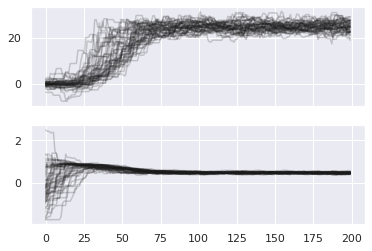

In [5]:
fig, ax = plt.subplots(2, sharex=True)
for i in range(2):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

### Restarting after burn-in

In [6]:
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000)

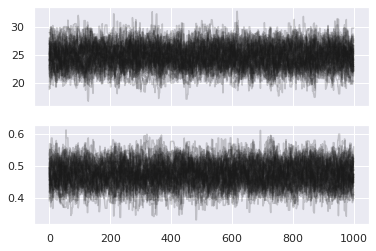

In [7]:
fig, ax = plt.subplots(2, sharex=True)
for i in range(2):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

### Visualizing the Posterior

Using the [corner.py](https://pypi.python.org/pypi/corner) package, we can take a look at this multi-dimensional posterior, along with the input values for the parameters:

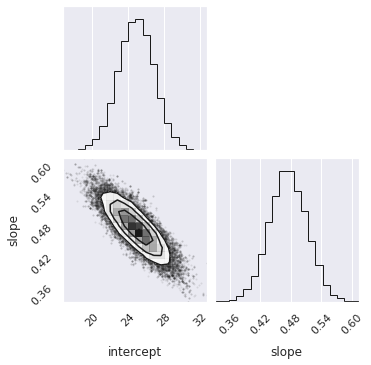

In [8]:
import corner
corner.corner(sampler.flatchain, labels=['intercept', 'slope']);

Another way to visualize the posterior is to plot the model over the data.
Each point in the two-dimensional space above corresponds to a possible model for our data; if we select ~100 of these at random and plot them over our data, it will give us a good idea of the spread in the model results:

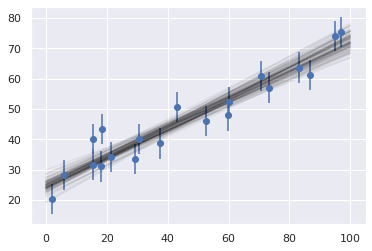

In [9]:
chain = sampler.flatchain

plt.errorbar(x, y, dy, fmt='o');

thetas = [chain[i] for i in np.random.choice(chain.shape[0], 100)]

xfit = np.linspace(0, 100)
for i in range(100):
    theta = thetas[i]
    plt.plot(xfit, theta[0] + theta[1] * xfit,
             color='black', alpha=0.05);

## Breakout: Linear Fit with Intrinsic Scatter

Above we have done a simple model, where the data is drawn from a straight line.

Often, however, we will be modeling relationships where there is some intrinsic scatter in the model itself: that is, even if the data were *perfectly* measured, they would not fall along a perfect straight line, but would have some (unknown) scatter about that line.

Here we'll make a slightly more complicated model in which we will fit for the slope, intercept, and intrinsic scatter all at once.

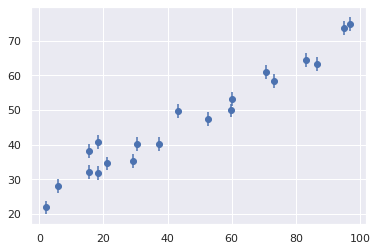

In [10]:
def make_data_scatter(intercept, slope, scatter,
                      N=20, dy=2, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(20)
    y = intercept + slope * x
    y += np.sqrt(dy ** 2 + scatter ** 2) * rand.randn(20)
    return x, y, dy * np.ones_like(x)


# (intercept, slope, intrinsic scatter)
theta = (25, 0.5, 3.0)
x, y, dy = make_data_scatter(*theta)
plt.errorbar(x, y, dy, fmt='o');

The following will walk you through using ``emcee`` to fit a model to this data.
Feel free to copy and adapt the code from the simple linear example above; if you'd like to see a solution, you can look at the [Solutions-03](Solutions-03.ipynb) notebook – but please resist the temptation to look before you have made a good attempt at this yourself!

### Define the prior, likelihood, and posterior

The likelihood for this model looks very similar to what we used above, except that the intrinsic scatter is added *in quadrature* to the measurement error.
If $\varepsilon_i$ is the measurement error on the point $(x_i, y_i)$, and $\sigma$ is the intrinsic scatter, then the likelihood should look like this:

$$
P(x_i,y_i\mid\theta) = \frac{1}{\sqrt{2\pi(\varepsilon_i^2 + \sigma^2)}} \exp\left(\frac{-\left[y_i - y(x_i;\theta)\right]^2}{2(\varepsilon_i^2 + \sigma^2)}\right)
$$

For the prior, you can use either a flat or symmetric prior on the slope and intercept, but on the intrinsic scatter $\sigma$ it is best to use a scale-invariant Jeffreys Prior:

$$
P(\sigma)\propto\sigma^{-1}
$$

As discussed before, this has the nice feature that the resulting posterior will not depend on the units of measurement.

In [11]:
# Define functions to compute the log-prior, log-likelihood, and log-posterior

# theta = [intercept, slope, scatter]

def log_prior(theta):
    # fill this in
    pass
    
def log_likelihood(theta, x, y, dy):
    # fill this in
    pass

def log_posterior(theta, x, y, dy):
    # fill this in
    pass

### Sampling from the Posterior

In [12]:
# Using emcee, create and initialize a sampler and draw 200 samples from the posterior.
# Remember to think about what starting guesses should you use!
# You can use the above as a template



### Visualizing the Chains

In [13]:
# Plot the three chains as above



### Resetting and getting a clean sample

In [ ]:
# Are your chains stabilized? Reset them and get a clean sample

### Visualizing the results

In [ ]:
# Use corner.py to visualize the three-dimensional posterior



In [ ]:
# Next plot ~100 of the samples as models over the data to get an idea of the fit

